In [4]:
import numpy as np
import os
import time
import glob
from numba import jit, njit

In [5]:
## Taken form the SAMoSA -Analysis library developed by Silke Henkes
## Refer for further details https://github.com/silkehenkes/SAMoSA
## Dated : June 2025

import pandas
import gzip

class ReadData:
  
	def __init__(self, filename,dialect):
		if filename.split('.')[-1] == 'gz':
			names = ['id', 'type', 'flag', 'radius', 'x','y','z', 'vx', 'vy', 'vz', 'nx', 'ny', 'nz']
			self.datafile = gzip.open(filename, newline='')
			line = self.datafile.readline()
			self.header_names = 0
			if line.startswith("#"):
				self.header_names = line[1:].strip().split()
			self.datafile.seek(0)	

		else:
			self.datafile = open(filename, newline='')
			line = self.datafile.readline()
			self.header_names = 0
			names = ['id', 'type', 'flag', 'radius', 'x','y','z', 'vx', 'vy', 'vz', 'nx', 'ny', 'nz']
			if line.startswith("#"):
				self.header_names = line[1:].strip().split()
			else:
				self.header_names = names
			self.datafile.seek(0)	
		self.dialect = dialect
		self.__read_data()

	

	# Read data using pandas. Simplify data structure for Configuration
	def __read_data(self):
		if self.dialect == "SAMoS":
			
			self.data = pandas.read_csv(self.datafile,sep=r"\s+", comment= "#", names = self.header_names)
			#
			# temp = self.data.columns
			#colshift = {}
			#for u in range(len(temp)-1): 
			#	colshift[temp[u]] = temp[u+1]
			#self.data.rename(columns = {temp[len(temp)-1]: 'garbage'},inplace=True)
			#self.data.rename(columns = colshift,inplace=True,errors="raise")
			#print(self.data.columns)
		elif self.dialect == "CCCPy":
			self.data = pandas.read_csv(self.datafile,header=0)
			# look of the header
			# currTime,xPos,yPos,xVel,yVel,polAngle,polVel,xPol,yPol,rad,glued
			# We need to muck about with the headers to distil this to a unified format
			# Classical samos header:
			#  id  type  flag  radius  x  y  z  vx  vy  vz  nx  ny  nz 
			self.data.rename(columns={"xPos": "x", "yPos": "y", "xVel": "vx", "yVel": "vy", "xPol": "nx", "yPol": "ny", "rad":"radius", "glued":"type"}, inplace=True,errors="raise")
			#print(self.data.columns)
		elif self.dialect == "CAPMD":
			self.data = pandas.read_csv(self.datafile,header=0)
		else:
			print("Unknown data format dialect!")
		


In [6]:
def extract_positions(files_path,tp):
    # extracts the positions from the .dat file and filter for the given  type

    files = sorted(glob.glob(files_path))

    positions = []

    for file in files:   
        read_file = ReadData(file, "SAMoS")
        read_data= read_file.data
        data1 = read_data[read_data['type']==tp]
        cur_positions = np.stack((data1['x'], data1['y'], data1['z'])).T
        positions.append(cur_positions)
    
    positions = np.asarray(positions)
    return positions

In [7]:
def extract_vel(files_path,tp):
    # extracts the velocities from the .dat file and filter for the given type

    files = sorted(glob.glob(files_path))

    velocities = []

    for file in files:   
        read_file = ReadData(file, "SAMoS")
        read_data= read_file.data
        data1 = read_data[read_data['type']==tp]
        cur_velocities = np.stack((data1['vx'], data1['vy'], data1['vz'])).T
        velocities.append(cur_velocities)
    
    velocities = np.asarray(velocities)
    return velocities


In [8]:
def extract_directors(files_path,tp):
    # extracts the directors/orientation from the .dat file and filter for the given type

    files = sorted(glob.glob(files_path))

    directors = []

    for file in files:   
        read_file = ReadData(file, "SAMoS")
        read_data= read_file.data
        data1 = read_data[read_data['type']==tp]
        cur_directors = np.stack((data1['nx'], data1['ny'], data1['nz'])).T
        directors.append(cur_directors)
    
    directors = np.asarray(directors)
    return directors

In [9]:
def extract_particle_radii(files_path):
    # extracts the particle radii from the .dat file and filter for the given type

    files = sorted(glob.glob(files_path))
    radii = []
    for file in files:   
        read_file = ReadData(file, "SAMoS")
        data1= read_file.data
        cur_radii = data1['radius']
        radii.append(cur_radii)
    
    radii = np.asarray(radii)
    return radii

In [10]:
'''
output_file_path = "/data1/pabshettiwar/Simulation_Softwares/SAMOS_ABP/tumoroid_system_alignments/1000-morse/pair_nematic/Seed-5/xi_1.0_J_0.5_dr_0.01_abp-p_0.3_ma_2.50_mD_0.08/output_*.dat"
dir_path = '/data1/pabshettiwar/Simulation_Softwares/SAMOS_ABP/tumoroid_system_alignments/1000-morse/pair_nematic/Seed-5/xi_1.0_J_0.5_dr_0.01_abp-p_0.3_ma_2.50_mD_0.08/'

files = sorted(glob.glob(output_file_path))

positions_ts = []

for i, file in enumerate(files):   
    read_file = ReadData(file, "SAMoS")
    data_read= read_file.data

    # extract type 1 particle
    data_1 = data_read[data_read['type']==1]
    position_cur = np.stack((data_1['x'], data_1['y']), axis = 1)    
    positions_ts.append(position_cur)
'''

'\noutput_file_path = "/data1/pabshettiwar/Simulation_Softwares/SAMOS_ABP/tumoroid_system_alignments/1000-morse/pair_nematic/Seed-5/xi_1.0_J_0.5_dr_0.01_abp-p_0.3_ma_2.50_mD_0.08/output_*.dat"\ndir_path = \'/data1/pabshettiwar/Simulation_Softwares/SAMOS_ABP/tumoroid_system_alignments/1000-morse/pair_nematic/Seed-5/xi_1.0_J_0.5_dr_0.01_abp-p_0.3_ma_2.50_mD_0.08/\'\n\nfiles = sorted(glob.glob(output_file_path))\n\npositions_ts = []\n\nfor i, file in enumerate(files):   \n    read_file = ReadData(file, "SAMoS")\n    data_read= read_file.data\n\n    # extract type 1 particle\n    data_1 = data_read[data_read[\'type\']==1]\n    position_cur = np.stack((data_1[\'x\'], data_1[\'y\']), axis = 1)    \n    positions_ts.append(position_cur)\n'

In [11]:
import alphashape
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiLineString, LineString, MultiPolygon
from shapely.plotting import plot_polygon
from pathlib import Path
import re

In [12]:
def get_shape(points,alpha):
    # uses alpha shape to obtain alpha shape and respective area, perimeter
    
    alpha_shape = alphashape.alphashape(points, alpha)
    #area = alpha_shape.area
    #perimeter = alpha_shape.length

    return alpha_shape #, area, perimeter

In [13]:
def plot_cells_2D(points):
    # takes in the total points [(x,y), .. ] as arguments to plot
    
    x_points = points[0]
    y_points = points[1]

    fig,ax = plt.subplots(constrained_layout=True)
    ax.scatter(x_points,y_points)
    ax.set_aspect('equal', adjustable='box')
    plt.gca().set_aspect('equal')
    plt.show()

In [14]:
def plot_alphashape(shape, points,frame = 1, outer_points= False,  dir = Path.cwd()):
    # arguments : alpha shape, original points, total number of time frames, directory to save output files(images) 
    
    fig, ax = plt.subplots(constrained_layout=True)
    ax.scatter(points.T[0], points.T[1], s=5)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-50,50)
    ax.set_ylim(-50,50)
    plot_polygon(shape, ax=ax, add_points=outer_points, facecolor='orange', alpha = 0.5)
    plt.savefig(os.path.join(dir, f"tumor_alphashape_test_{frame:04d}.png"), dpi = 100, format = 'png', )
    plt.close()
    return None

In [15]:
def get_shape_index(peri, area):
    # shape index measures closeness to circle
    # si = perimeter/ 2* (pi* area)**1/2 
    si = peri / (2* np.sqrt(np.pi * area))
    return si


In [16]:
def MSD(positions:np.ndarray):
    # simple msd calculations ==> |x(t) - x(0)|**2 for frame(t) and averaged over all particles for each frame i.e ensemble average
    # there is no moving tau window used here  
    msd = np.mean(np.sum((positions - positions[0,:,:][np.newaxis,:,:])**2, axis = 2), axis = 1)
    return msd


In [17]:
def radius_of_gyration(positions):
    # Calculates the radius of gyration
    
    N = np.shape(positions)[0]
    sum_r = np.sum(positions, axis = 0)
    sum_r2 = np.sum(np.sum(positions**2, axis=1))
    rg_2 = sum_r2/N - np.sum(sum_r**2)/N**2
    return np.sqrt(rg_2)

In [18]:

def center_of_mass(positions):
    # Caculates the center of mass
    
    N = np.shape(positions)[0]
    sum_r = np.sum(positions,axis = 0)
    return sum_r/N

In [19]:
def get_invasion_radius_shape(positions, shape):
    # takes in all positions of all the points and alpha shape
    # Calculates the distance between com and boundary points and returns the maximum of the distances

    if isinstance(shape, Polygon):
        boundary_points = list(shape.exterior.coords)
    elif isinstance(shape,LineString) or isinstance(shape, MultiLineString):
        boundary_points = list(shape.coords)
    
    com = center_of_mass(positions)
    dist_com = np.sum((boundary_points - com)**2, axis =1)**0.5
    invasion_radius = np.max(dist_com)

    return invasion_radius

In [20]:
def get_invasion_radius(positions):
    # Calculates the distane between farthest particle and center of mass
    # returns this distance  

    com = center_of_mass(positions)
    dist_com = np.sum((positions - com)**2, axis =1)**0.5
    invasion_radius = np.max(dist_com)

    return invasion_radius

In [21]:
def get_boundary_length(shape):
    # returns the boundary length for largest polygon structure

    if isinstance(shape, Polygon):
        boundary_length = shape.length
        print(boundary_length)
    elif isinstance(shape,MultiPolygon):
        largest_poly = max(shape.geoms, key = lambda p:p.area)
        boundary_length = largest_poly.length
    
    return boundary_length

In [22]:
def get_vicsek_op(velocities, act_strength):
    # obtains the instataneous vicsek order parameter
    order_param = np.sum(velocities)/ (np.shape(velocities)[0] * act_strength )
    return order_param 

In [23]:
def get_vicsek_director_op(directors):
    return np.sum(directors) / np.shape(directors)[0]

In [24]:
def save_file(data, dir):
    # pass the dictionary for the data and saving directory/location
    # if successful return true otherwise false
    try:
        with open(os.path.join(dir, "analysis_data.npz"), "wb") as fil:
            np.savez(fil, traj = data["trajectory"], vel = data["velocities"], msd = data["msd"], rog =data["rog"], vicsek =data["vicsek_op"],
                     inv_rad = data["invasion_radius"], boundary_len = data["boundary_length"])
    except:
        print("\n Error,  Data not saved")


In [25]:
def save_data(data, type, dir, **kwargs):
    try:
        with open(os.path.join(dir, f"{type}_data.npz"), "wb") as fil:
            np.savez(fil, data=data, **kwargs)
            
    except:
        print("\n Error, data not saved ")

In [26]:
def generate_traj_shapes(traj, alpha, dir):

    for frame in range(np.shape(traj)[0]):
        points_cur = traj[frame]
        a_shape = get_shape(points_cur, alpha)
        # a_shape, area, perimeter = get_shape(points_cur, alpha)
        plot_alphashape(a_shape, points_cur, frame = frame, outer_points= False, dir = dir ) 


KeyboardInterrupt: 

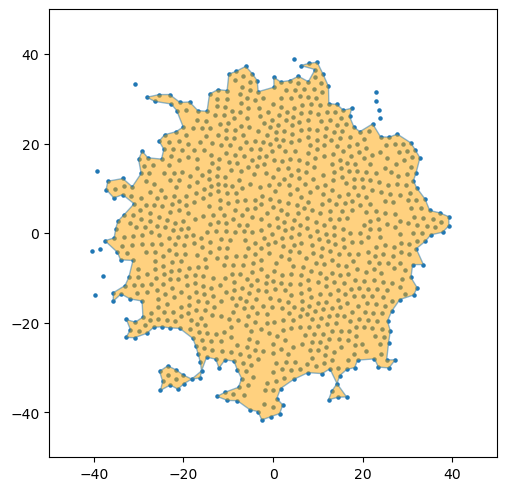

In [ ]:
data_dir_path = '/data1/pabshettiwar/Simulation_Softwares/SAMOS_ABP/tumoroid_system_alignments/1000-morse/pair_nematic/phase_diagram/new'
alpha = 0.5

for dir in os.listdir(data_dir_path):

    cur_path = os.path.join(data_dir_path, dir)
    
    cur_output_files = os.path.join(cur_path, 'output_*.dat')
    
    cur_traj = extract_positions(cur_output_files, tp=1)

    if not os.path.isdir(os.path.join(cur_path, 'alpha_images')):
        os.mkdir(os.path.join(cur_path, 'alpha_images'))
    
    img_path = os.path.join(cur_path, 'alpha_images')
    
    generate_traj_shapes(cur_traj[:,:,:2], alpha, dir = img_path )

In [ ]:
data_dir_path = '/disks/pi-henkes/pabshettiwar/1000-morse/pair_nematic/phase_diagram'
alpha =0.5
time = np.linspace(0, 2500, 1000)

for dir in os.listdir(data_dir_path):

    cur_path = os.path.join(data_dir_path, dir)

    #if(os.path.isfile(os.path.join(cur_path, "analysis_data.npz"))):
    #    continue

    dir_name = str(os.path.basename(cur_path))

    #if os.path.isdir(dir_name):
    #    continue

    srch = re.search('p_', dir_name)
    span = list(srch.span())
    
    srh_end = span[-1]
    act_strength = float(dir_name[srh_end:srh_end+3])
    if(act_strength == 0.0):
        act_strength = 0.05

    cur_output_files = os.path.join(cur_path, 'output_*.dat')

    cur_traj = extract_positions(cur_output_files, tp=1)
    cur_vel = extract_vel(cur_output_files, tp=1)

    # calculate MSD
    msd_cur_ts = np.array(MSD(cur_traj[:]))

    # Calculate Radius of Gyration
    rog_ts = []

    for i in range(np.shape(cur_traj[:])[0]):
        rog = radius_of_gyration(cur_traj[i])
        rog_ts.append(rog)
    
    rog_ts = np.array(rog_ts)
    
    # Calculate Vicsek order paramater
    vicsek_op_ts = []

    for i in range(np.shape(cur_vel[:])[0]):
        vicsek_op = get_vicsek_op(cur_vel[i],act_strength)
        vicsek_op_ts.append(vicsek_op)
    
    vicsek_op_ts = np.array(vicsek_op_ts)
    
    # Calculate the Invasion Radius
    inv_radius_ts = []

    for i in range(np.shape(cur_traj[:])[0]):
        inv_rad = get_invasion_radius(cur_traj[i])
        inv_radius_ts.append(inv_rad)

    inv_radius_ts = np.array(inv_radius_ts)

    # Get alpha shapes for trajectorycontinue
    shapes_ts = []

    for i in range(np.shape(cur_traj[:])[0]):
        shape = get_shape(cur_traj[i][:][:2], alpha)
        shapes_ts.append(shape)
    

    # Calculate the boundary length
    boundary_len_ts = []

    for i in range(np.shape(cur_traj[:])[0]):
        shape = get_shape(cur_traj[i,:, :2], alpha)
        boundary_len = shape.length
        boundary_len_ts.append(boundary_len)
    
    boundary_len_ts = np.array(boundary_len_ts)

    analysis_data = {"trajectory": cur_traj[:], "velocities": cur_vel[:], "msd":msd_cur_ts, "rog":rog_ts, "vicsek_op":vicsek_op_ts, 
                     "invasion_radius":inv_radius_ts, "alpha_shapes":shapes_ts, "boundary_length": boundary_len_ts }
    

    #save_file(analysis_data, dir = cur_path)
    
    save_data(msd_cur_ts, 'msd', dir= cur_path, time=time)
    save_data(vicsek_op_ts, 'vicsek_op', dir= cur_path, time=time)
    save_data(rog_ts, 'rog', dir= cur_path, time=time)
    save_data(inv_radius_ts, 'invasion_radius', dir= cur_path, time=time)
    save_data(boundary_len_ts, 'boundary_len', dir= cur_path, time=time)
    

    '''    
    fig,ax = plt.subplots()
    ax.loglog(msd_cur)
    plt.savefig(os.path.join(cur_path, f"msd_c.png"), format= "png", dpi = 200)
    plt.close()

    fig,ax = plt.subplots()
    ax.plot(rog_all)
    plt.savefig(os.path.join(cur_path,f"Radius_of_gyration_c.png"), format="png", dpi = 200)
    plt.close()
    '''


In [ ]:
def plot_analysis_data(file_name, dir_name):

    msd_all = []
    rog_all = []
    inv_rad_all = []
    vicsek_all = []
    act_all = []
    J_all=[]

    for dir in sorted(os.listdir(dir_name)):
        cur_path = os.path.join(dir_name, dir)

        if not os.path.isdir(cur_path):
            continue

        cur_dir_name = str(os.path.basename(dir))
        print(cur_dir_name)

        # obtain the activity from name
        search = re.search('p_', cur_dir_name)
        if search:
            end = search.span()[1]
        
        activity = float(cur_dir_name[end:end+3])
        act_all.append(activity)


        # obtain alignment strength from name of the directory
        search2 = re.search('J_', cur_dir_name)
        if search2:
            end2 = search2.span()[1]

        J = float(cur_dir_name[end2:end2+3])
        J_all.append(J)

        fil = open(os.path.join(cur_path,file_name), "rb") 
        analysis_data = np.load(fil)
        msd = analysis_data['msd']
        rog = analysis_data['rog']
        inv_rad = analysis_data['inv_rad']
        vicsek_op = analysis_data['vicsek']
        
        msd_all.append(msd)
        rog_all.append(rog)
        inv_rad_all.append(inv_rad)
        vicsek_all.append(vicsek_op)
        
    

    fig,ax = plt.subplots()
    plt.title("MSD as function of activity")
    for l in range(len(msd_all)):
        ax.loglog(msd_all[l], label= f"p = {act_all[l]}, J = {J_all[l]}")
    plt.legend()    
    plt.xlabel("time")
    plt.ylabel("MSD")
    plt.savefig(os.path.join(dir_name, f"msd_all.png"), format= "png", dpi = 400)
    plt.close()

    fig,ax = plt.subplots()
    plt.title("Radius_of_gyration")



In [239]:
plot_analysis_data("analysis_data.npz","/data1/pabshettiwar/Simulation_Softwares/SAMOS_ABP/tumoroid_system_alignments/1000-morse/pair_polar/Seed-5")

xi_1.0_J_0.5_dr_0.01_abp-p_0.3_ma_2.50_mD_0.08
xi_1.0_J_0.5_dr_0.01_abp-p_0.5_ma_2.50_mD_0.08
xi_1.0_J_0.5_dr_0.01_abp-p_0.7_ma_2.50_mD_0.08
xi_1.0_J_0.8_dr_0.01_abp-p_0.3_ma_2.50_mD_0.08
xi_1.0_J_0.8_dr_0.01_abp-p_0.5_ma_2.50_mD_0.08
xi_1.0_J_0.8_dr_0.01_abp-p_0.7_ma_2.50_mD_0.08
